https://www.kaggle.com/code/burakdervisoglu/credit-risk-analysis-randomforest-and-lightgbm/notebook

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, GridSearchCV,train_test_split, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import  classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
# from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

In [6]:
pd.set_option('display.max_columns', None)

df_path = "loan.csv"
df = pd.read_csv(df_path)

In [7]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [9]:
def check_data(df):
    print(f'HEAD {df.head()}')
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print(f'TAIL {df.tail()}')
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print(f'SHAPE: {df.shape}')
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print(f'INFO: {df.info()}')
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print(f'COLUMNS: {df.columns}')
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print(f'DESCRIBE {df.describe().T}')
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
check_data(df)

HEAD     Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1

In [12]:
# Seperating the categorical and numerical columns
cat_cols = [col for col in df.columns if df[col].dtypes == 'O' and 'Loan_ID' not in col]
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and 'Credit_History' not in col]

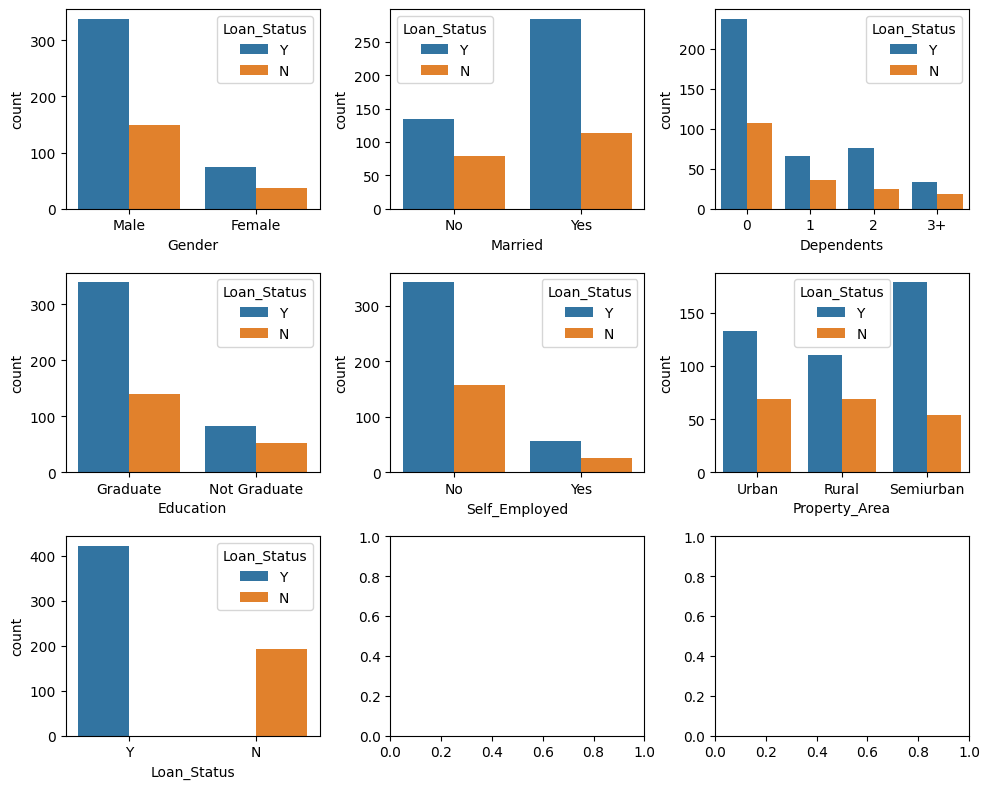

In [16]:
# Visualisation of categorical columns
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,8))
axs = axs.flatten()
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, hue='Loan_Status',ax=axs[i])
fig.tight_layout()
plt.show()

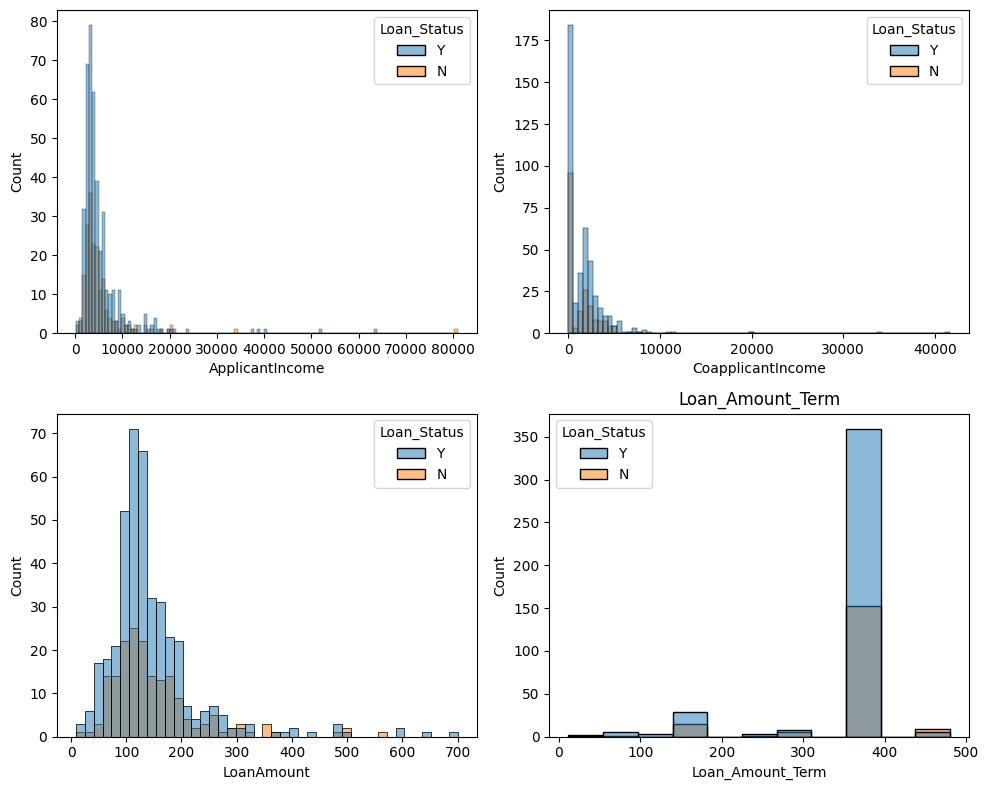

In [19]:
# Visualisation of numerical columns
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(10,8))
axs = axs.flatten()
for i,col in enumerate(num_cols):
    sns.histplot(x= col, data= df,hue= 'Loan_Status', ax=axs[i],kde=False)
    plt.title(col)
fig.tight_layout()
#fig.delaxes(axs[4])
plt.show()

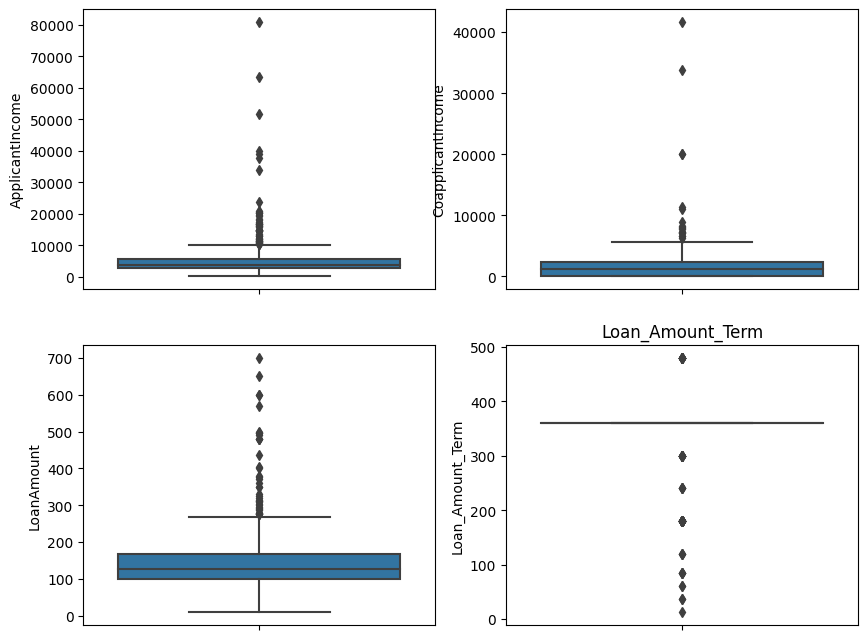

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axs = axs.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(y=col,data=df,ax=axs[i])
    plt.title(col)
plt.show()

In [22]:
# Check count of NULL values
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [23]:
# we fill NaN variable, for numerical columns we use median
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())  # Median
df.fillna(df.groupby(['Gender','Married','Education'])['Loan_Amount_Term'].transform('median'))  # grouped-median
df.loc[(df['LoanAmount'] > df['LoanAmount'].mean()) & (df['Credit_History'] == 0),'Credit_History'] = 1   # If more than mean then 1 else 0

In [24]:
null_col_cat = [col for col in df.columns if df['Dependents'].isnull().sum() > 1 and df[col].dtypes == 'O' and 'Loan_ID' not in col]
null_col_num = [col for col in df.columns if df['Dependents'].isnull().sum() > 1 and df[col].dtypes != 'O']

In [25]:
# that can be use for cat_cols beacause cat cols can fill with mode 
def null_col_fill(null_cols):
    for col in null_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
null_col_fill(null_col_cat)

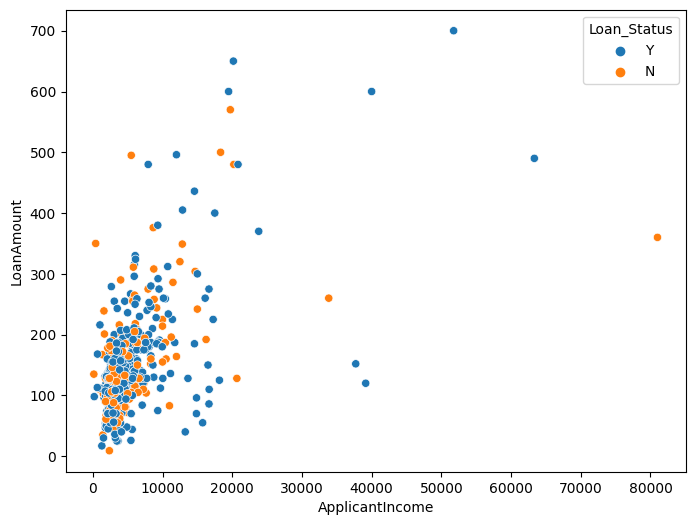

In [26]:
fig, axs = plt.subplots(figsize=(8,6))
sns.scatterplot(x='ApplicantIncome', y='LoanAmount', hue='Loan_Status', data=df)
plt.show()

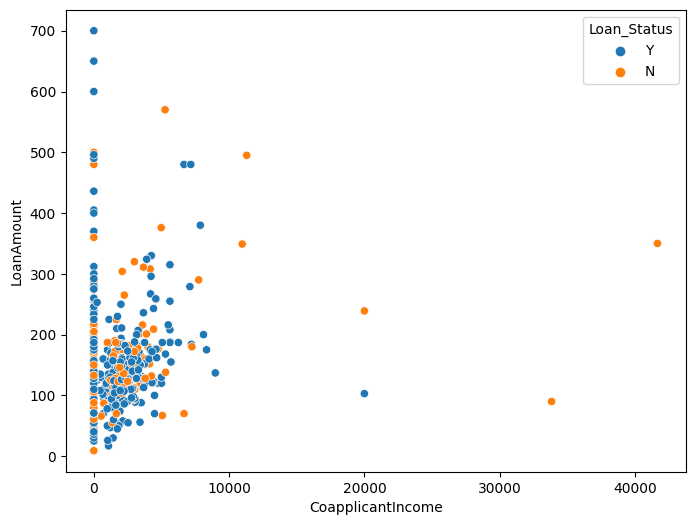

In [27]:
fig, axs = plt.subplots(figsize=(8,6))
sns.scatterplot(x='CoapplicantIncome',y='LoanAmount', hue='Loan_Status',data=df)
plt.show()

In [28]:
df['Total_Income'] = df['CoapplicantIncome'] + df['ApplicantIncome']
df['Remainder_Loan'] = df['LoanAmount'] - df['Loan_Amount_Term']
# df['Coapp_App_Minus'] = df['ApplicantIncome'] - df['CoapplicantIncome']
# Payment Duration
# df['Payment Duration'] = df['LoanAmount'] / df['Loan_Amount_Term']

In [29]:
# Total Loan Amount / Total_Income
(round(df['LoanAmount'] / df['Total_Income'],2) * 100).head()

0    2.0
1    2.0
2    2.0
3    2.0
4    2.0
dtype: float64